In [3]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio
import skimage as ski

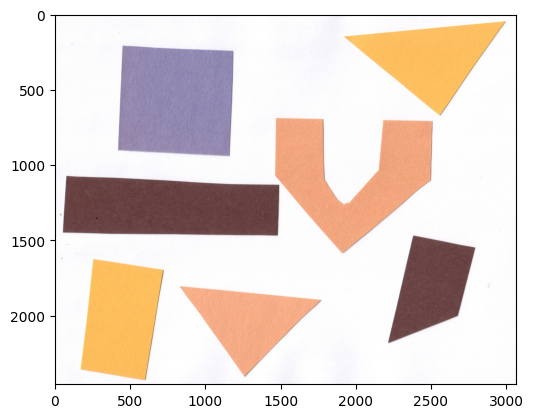

In [2]:
# load the image
shapes = iio.imread(uri="data/shapes-01.jpg")
plt.imshow(shapes);

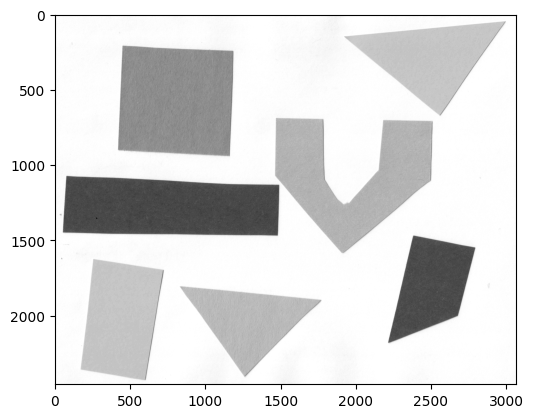

In [3]:
# convert the image to grayscale
gray_shapes = ski.color.rgb2gray(shapes)
plt.imshow(gray_shapes, cmap="gray");

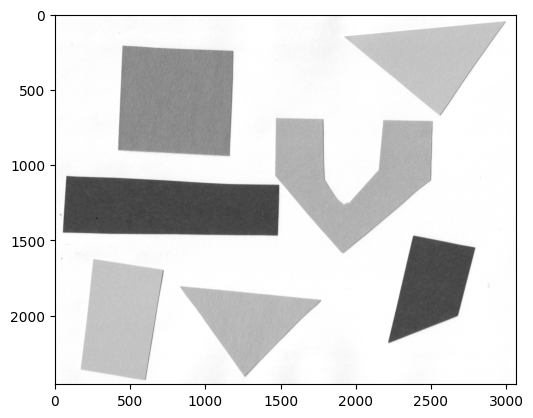

In [4]:
# blur the image to denoise
blurred_shapes = ski.filters.gaussian(gray_shapes, sigma=1.0)
plt.imshow(blurred_shapes, cmap="gray");

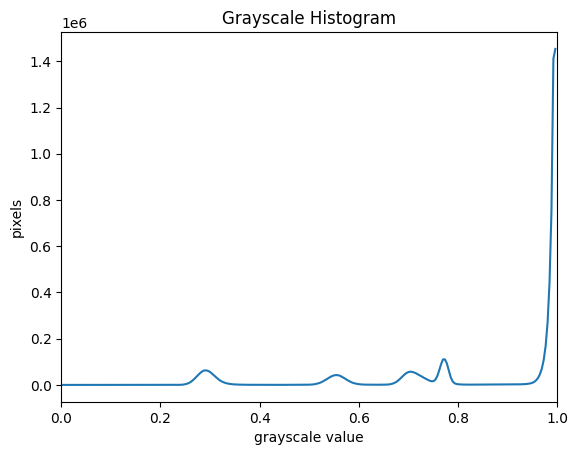

In [5]:
# create a histogram of the blurred grayscale image
histogram, bin_edges = np.histogram(blurred_shapes, bins=256, range=(0.0, 1.0))

plt.plot(bin_edges[0:-1], histogram)
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim(0, 1.0);

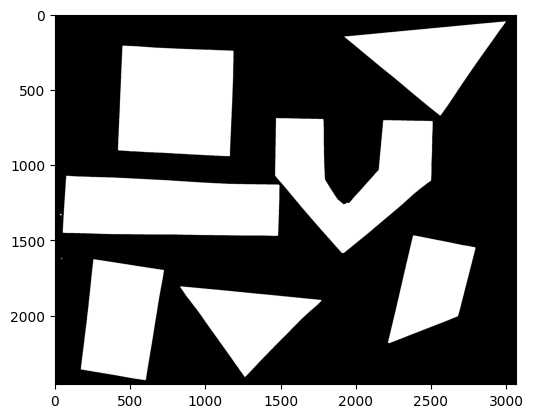

In [6]:
# create a mask based on the threshold
t = 0.85
binary_mask = blurred_shapes < t
plt.imshow(binary_mask, cmap="gray");

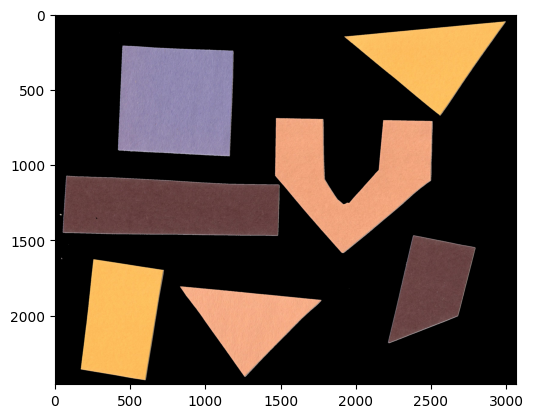

In [7]:
# use the binary_mask to select the "interesting" part of the image
selection = shapes.copy()
selection[~binary_mask] = 0
plt.imshow(selection);

In [8]:
t = ski.filters.threshold_otsu(blurred_shapes)

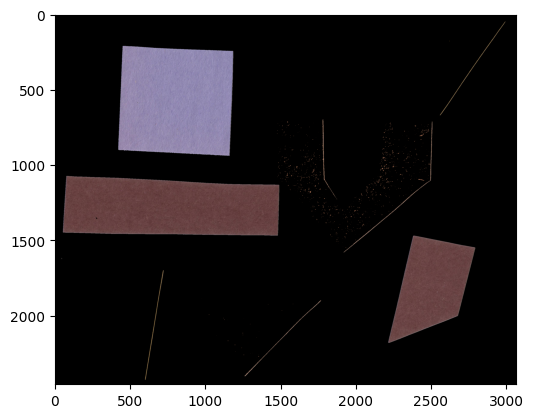

In [9]:
binary_mask = blurred_shapes < t
selection[~binary_mask] = 0
plt.imshow(selection);

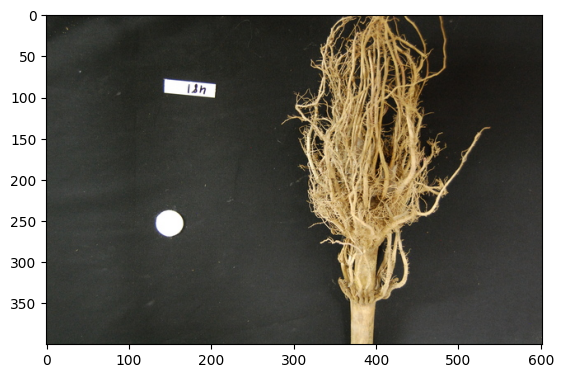

In [10]:
maize_roots = iio.imread(uri="data/maize-root-cluster.jpg")
plt.imshow(maize_roots);

(0.0, 1.0)

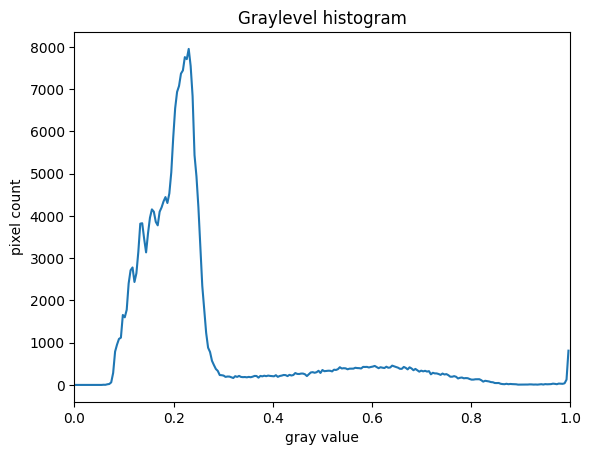

In [11]:
maize_roots = iio.imread(uri="data/maize-root-cluster.jpg")

# convert the image to grayscale
gray_image = ski.color.rgb2gray(maize_roots)

# blur the image to denoise
blurred_image = ski.filters.gaussian(gray_image, sigma=1.0)

# show the histogram of the blurred image
histogram, bin_edges = np.histogram(blurred_image, bins=256, range=(0.0, 1.0))
fig, ax = plt.subplots()
plt.plot(bin_edges[0:-1], histogram)
plt.title("Graylevel histogram")
plt.xlabel("gray value")
plt.ylabel("pixel count")
plt.xlim(0, 1.0)

In [12]:
# perform automatic thresholding
t = ski.filters.threshold_otsu(blurred_image)
print("Found automatic threshold t = {}.".format(t))

Found automatic threshold t = 0.4116003928683858.


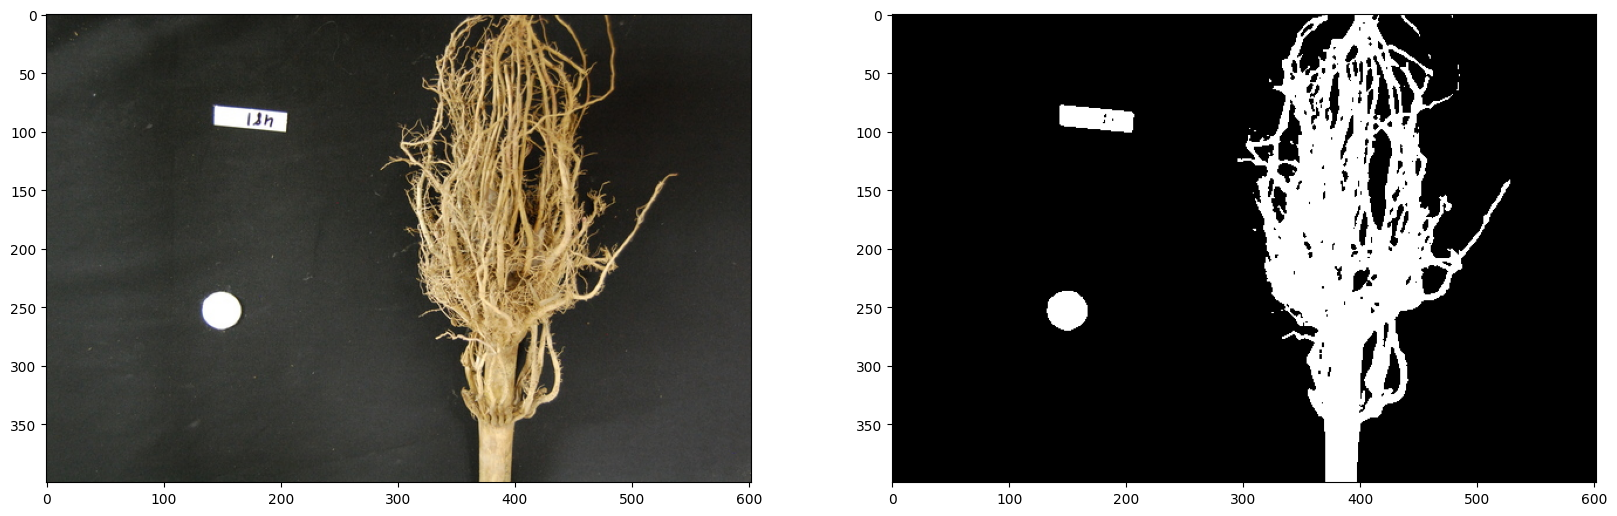

In [13]:
# create a binary mask with the threshold found by Otsu's method
binary_mask = blurred_image > t
fig, ax = plt.subplots(1,2, figsize=(20,8))
ax[0].imshow(maize_roots)
ax[1].imshow(binary_mask, cmap="gray");

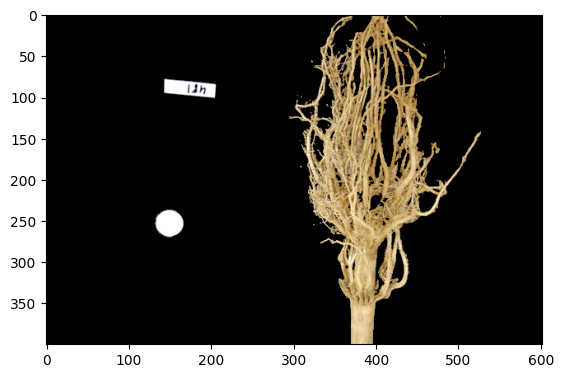

In [14]:
selection = maize_roots.copy()
selection[~binary_mask] = 0
plt.imshow(selection);

In [15]:
rootPixels = np.count_nonzero(binary_mask)
rootPixels, rootPixels / np.prod(binary_mask.shape)

(34805, 0.1445390365448505)

In [16]:
import glob
all_files = glob.glob("data/trial-*.jpg")
all_files

['data/trial-016.jpg',
 'data/trial-020.jpg',
 'data/trial-293.jpg',
 'data/trial-216.jpg']

In [17]:
def measure_root_mass(filename, sigma=1.0):

    image = iio.imread(uri=filename, mode="L")

    blurred_image = ski.filters.gaussian(image, sigma=sigma)

    t = ski.filters.threshold_otsu(blurred_image)
    binary_mask = blurred_image > t

    rootPixels = np.count_nonzero(binary_mask)
    fraction = rootPixels / np.prod(binary_mask.shape)

    return fraction

measure_root_mass("data/trial-016.jpg")

0.04735871010638298

In [18]:
for file in all_files:
    fraction = measure_root_mass(file, sigma=3.0)
    print(f"{file}: {fraction}")

data/trial-016.jpg: 0.05361801861702128
data/trial-020.jpg: 0.06559640957446808
data/trial-293.jpg: 0.14084873670212766
data/trial-216.jpg: 0.1449468085106383


In [26]:
def enhanced_root_mass(filename, sigma):

    # read the original image, converting to grayscale on the fly
    image = iio.imread(uri=filename, mode="L")

    # blur before thresholding
    blurred_image = ski.filters.gaussian(image, sigma=sigma)

    # perform binary thresholding to mask the white label and circle
    binary_mask = blurred_image < 0.95
    
    # perform automatic thresholding to produce a binary image
    t = ski.filters.threshold_otsu(blurred_image[binary_mask])
    
    binary_mask = (t < blurred_image) & (blurred_image < 0.95)
    
    #print(f"Threshold = {t}")
    
    # determine root mass ratio
    rootPixels = np.count_nonzero(blurred_image[binary_mask])
    w = binary_mask.shape[1]
    h = binary_mask.shape[0]
    density = rootPixels / (w * h)

    return density

import glob
all_files = glob.glob("data/trial-*.jpg")
for filename in all_files:
    density = enhanced_root_mass(filename=filename, sigma=1.5)
    # output in format suitable for .csv
    print(filename, density, sep=",")

data/trial-016.jpg,0.046261136968085106
data/trial-020.jpg,0.05887167553191489
data/trial-293.jpg,0.1319044215425532
data/trial-216.jpg,0.13712067819148935


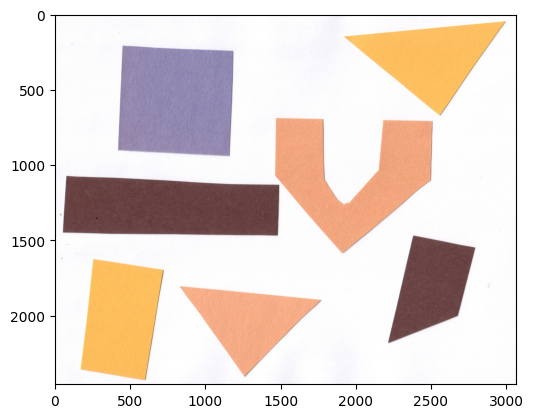

In [19]:
shapes = iio.imread("data/shapes-01.jpg")
plt.imshow(shapes);

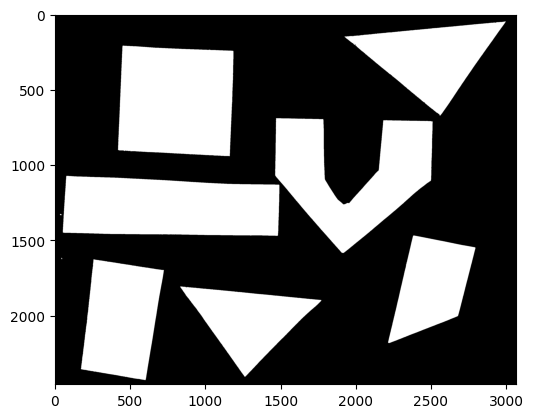

In [20]:
gray_image = ski.color.rgb2gray(shapes)
blurred_image = ski.filters.gaussian(gray_image, sigma=1.0)
binary_mask = blurred_image < 0.81
plt.imshow(binary_mask, cmap="gray");

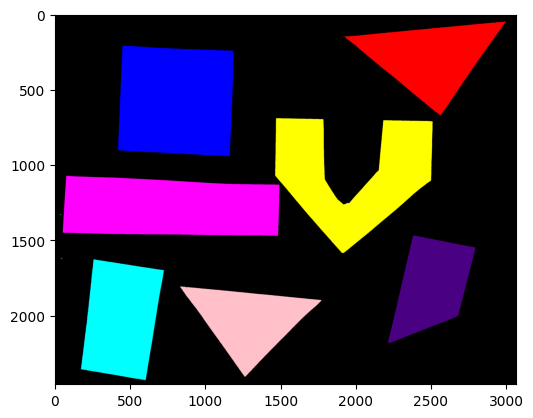

In [21]:
labeled_image, count = ski.measure.label(binary_mask, connectivity=2, return_num=True)
color_labeled_image = ski.color.label2rgb(labeled_image)
plt.imshow(color_labeled_image);

In [22]:
count

9

In [23]:
# compute object features and extract object areas
object_features = ski.measure.regionprops(labeled_image)
object_labels = np.array([ objf["label"] for objf in object_features ])
object_areas = np.array([ objf["area"] for objf in object_features ])
object_labels, object_areas
large_objects = object_labels[object_areas > 100000]
large_objects

array([1, 2, 3, 4, 6, 8, 9])

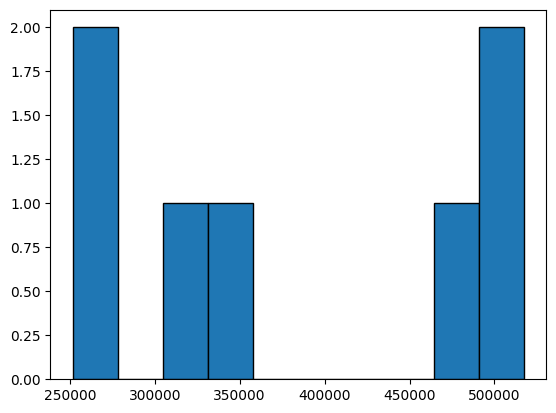

In [24]:
plt.hist(object_areas[object_areas > 100000], edgecolor="black");

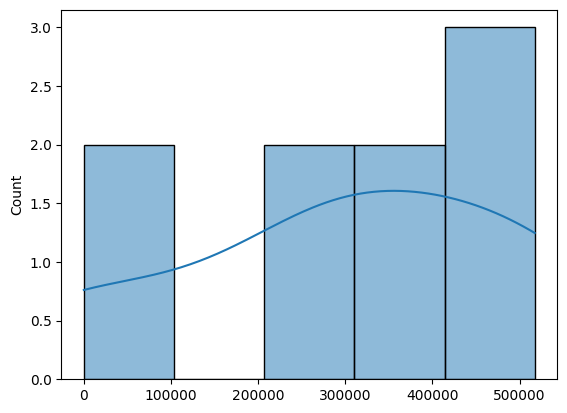

In [25]:
import seaborn as sns
sns.histplot(object_areas, kde=True);

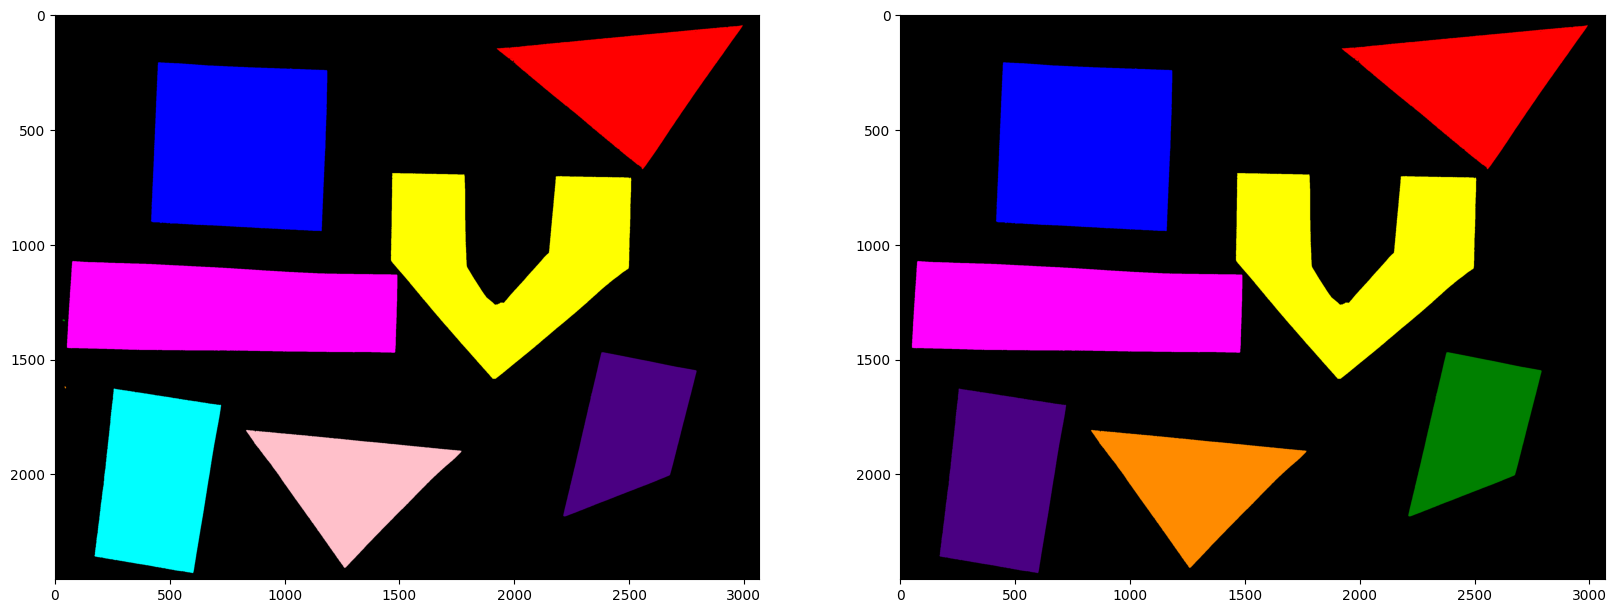

In [26]:
fix, ax = plt.subplots(1,2, figsize=(20,10))

min_area = 100000
connectivity = 2

labeled_image, count = ski.measure.label(binary_mask, connectivity=connectivity, return_num=True)
color_label_image = ski.color.label2rgb(labeled_image)
ax[0].imshow(color_label_image)

object_mask = ski.morphology.remove_small_objects(binary_mask, min_size=min_area)
labeled_image, n = ski.measure.label(object_mask, connectivity=connectivity, return_num=True)
color_label_image = ski.color.label2rgb(labeled_image)
ax[1].imshow(color_label_image);

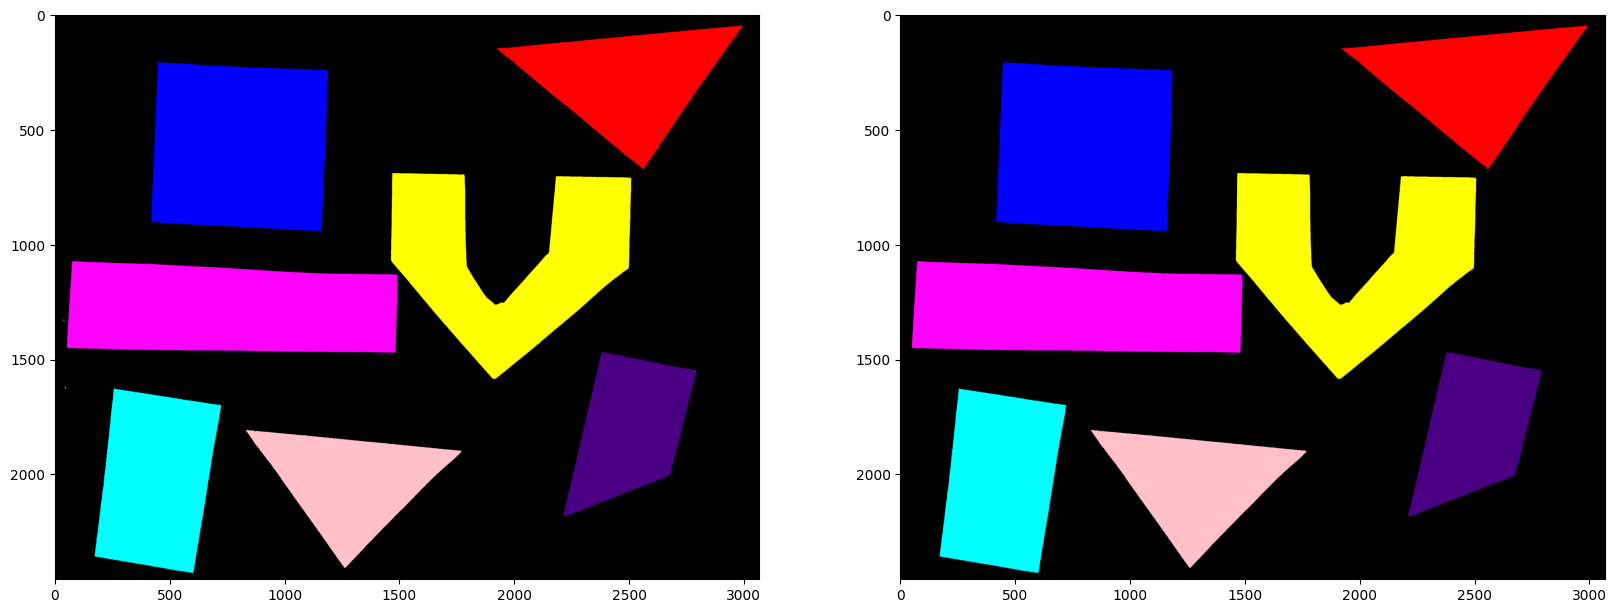

In [27]:
min_area = 100000

fix, ax = plt.subplots(1,2, figsize=(20,10))
labeled_image, count = ski.measure.label(binary_mask, connectivity=2, return_num=True)
color_label_image = ski.color.label2rgb(labeled_image)
ax[0].imshow(color_label_image)

object_labels = np.array([ objf["label"] for objf in object_features ])
object_areas = np.array([ objf["area"] for objf in object_features ])
large_objects = object_labels[object_areas > min_area]

color_label_image[~np.isin(labeled_image, large_objects)] = 0

ax[1].imshow(color_label_image);

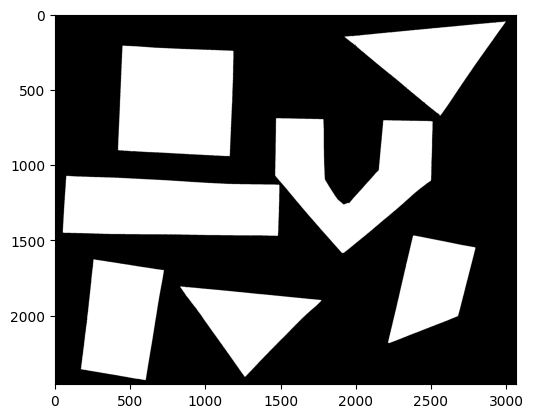

In [28]:
mask = np.isin(labeled_image, large_objects)
plt.imshow(mask, cmap="gray");

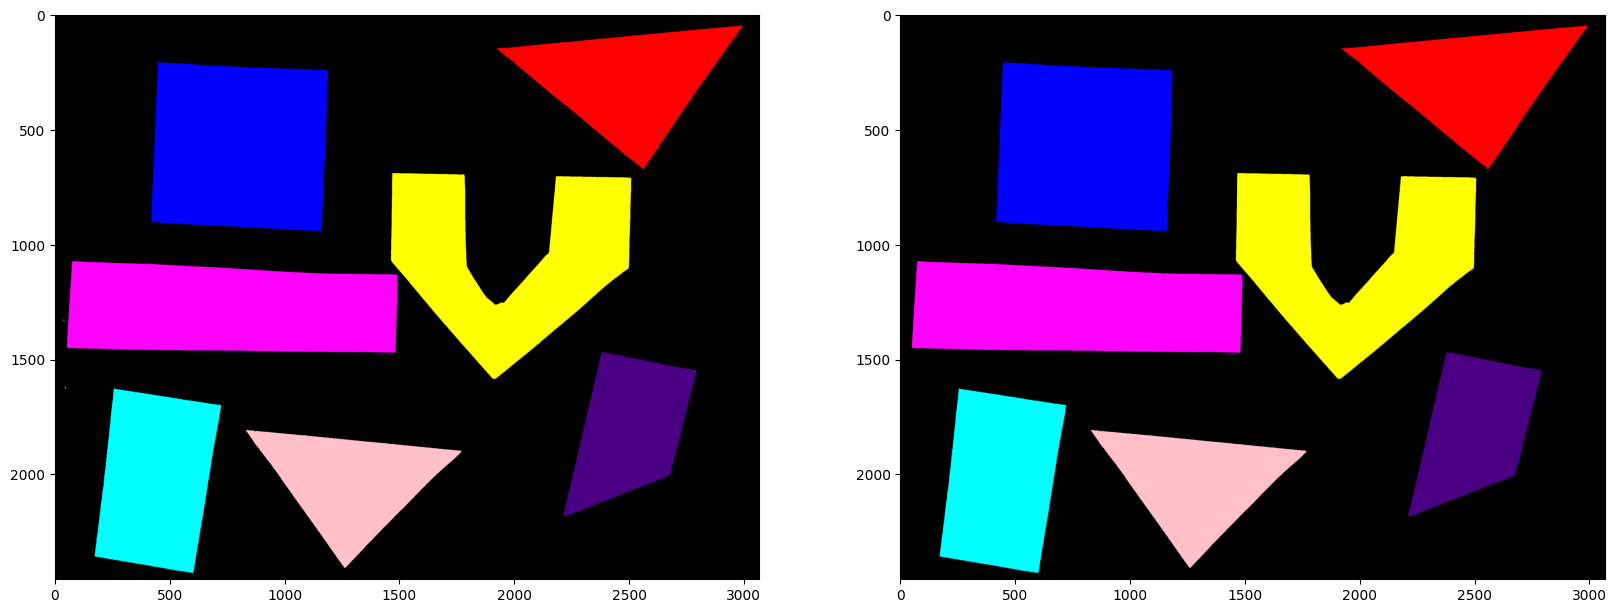

In [29]:
min_area = 100000

fix, ax = plt.subplots(1,2, figsize=(20,10))
labeled_image, count = ski.measure.label(binary_mask, connectivity=2, return_num=True)
color_label_image = ski.color.label2rgb(labeled_image)
ax[0].imshow(color_label_image)

object_labels = np.array([ objf["label"] for objf in object_features ])
object_areas = np.array([ objf["area"] for objf in object_features ])

for object_id, objf in enumerate(object_features, start=1):
    if objf["area"] < min_area:
        color_label_image[labeled_image == objf["label"]] = 0

ax[1].imshow(color_label_image);